# Connect Four AI (Minimax + Alpha–Beta)

This notebook implements a playable Connect Four with:
- A clean board representation
- Depth-limited **Minimax**
- **Alpha–Beta pruning** with move ordering
- A practical **heuristic evaluation** (window scoring + center control)
- Simple **CLI-style** play and **experiments** (nodes expanded, timing)


## How to use
- Run cells from top to bottom.
- Use `play_human_vs_ai()` to play against the AI in the terminal-like prompt.
- Use the **Experiments** section to compare Minimax vs Alpha–Beta.


In [1]:
import math, random, time
from dataclasses import dataclass
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt

ROWS, COLS = 6, 7
EMPTY, MAX, MIN = 0, 1, -1   # MAX is the AI by default
CENTER_COL = COLS // 2

# For instrumentation (experiments)
class Counter:
    def __init__(self):
        self.nodes = 0
        self.cutoffs = 0
    def reset(self):
        self.nodes = 0
        self.cutoffs = 0

global_counter = Counter()


## Board Representation
We use a simple 2D list: `board[r][c]` with values in `{0, 1, -1}` for empty/MAX/MIN.


In [2]:
@dataclass
class State:
    board: List[List[int]]
    player: int   # whose turn: MAX (1) or MIN (-1)

def new_state() -> State:
    return State([[EMPTY for _ in range(COLS)] for _ in range(ROWS)], MAX)

def copy_state(s: State) -> State:
    return State([row[:] for row in s.board], s.player)

def actions(s: State) -> List[int]:
    return [c for c in range(COLS) if s.board[0][c] == EMPTY]

def result(s: State, a: int) -> State:
    ns = copy_state(s)
    # drop disc in column a
    for r in range(ROWS-1, -1, -1):
        if ns.board[r][a] == EMPTY:
            ns.board[r][a] = s.player
            break
    ns.player = -s.player
    return ns

def in_bounds(r,c): 
    return 0 <= r < ROWS and 0 <= c < COLS

# Winner / terminal detection
DIRS = [(0,1),(1,0),(1,1),(1,-1)]

def line_winner_at(board, r, c):
    player = board[r][c]
    if player == EMPTY: 
        return None
    for dr, dc in DIRS:
        count = 1
        for k in range(1,4):
            rr, cc = r + dr*k, c + dc*k
            if in_bounds(rr,cc) and board[rr][cc] == player:
                count += 1
            else:
                break
        if count >= 4:
            return player
    return None

def winner(s: State) -> Optional[int]:
    for r in range(ROWS):
        for c in range(COLS):
            w = line_winner_at(s.board, r, c)
            if w:
                return w
    return None

def terminal_test(s: State) -> bool:
    return winner(s) is not None or all(s.board[0][c] != EMPTY for c in range(COLS))

def utility(s: State) -> int:
    w = winner(s)
    if w == MAX: return 10**9
    if w == MIN: return -10**9
    return 0

def print_board(s: State):
    symbols = {EMPTY:'.', MAX:'X', MIN:'O'}
    for r in range(ROWS):
        print(' '.join(symbols[v] for v in s.board[r]))
    print('0 1 2 3 4 5 6')


## Heuristic Evaluation
We score all contiguous windows of 4 cells horizontally, vertically, and diagonally.
Features:
- Window patterns (3-in-a-row with one empty, 2-in-a-row with two empty, etc.)
- Center column bias (favor occupying the middle)
- Immediate win/loss are handled by `utility()` when terminal; we also include
  **near-term threats** implicitly through window scoring.


In [3]:
def score_window(window: List[int], player: int) -> int:
    opp = -player
    count_p = window.count(player)
    count_o = window.count(opp)
    empties = window.count(EMPTY)
    # Blocked window: both players present
    if count_p > 0 and count_o > 0:
        return 0
    # Scoring (tune as needed)
    if count_p == 3 and empties == 1: return 5
    if count_p == 2 and empties == 2: return 2
    if count_o == 3 and empties == 1: return -5
    if count_o == 2 and empties == 2: return -2
    return 0

def evaluate(s: State, player=MAX) -> int:
    if terminal_test(s):
        return utility(s)  # strong terminal values

    total = 0
    # Center column bias
    center_col_vals = [s.board[r][CENTER_COL] for r in range(ROWS)]
    total += 3 * center_col_vals.count(player)
    total -= 3 * center_col_vals.count(-player)

    # Horizontal
    for r in range(ROWS):
        for c in range(COLS-3):
            w = [s.board[r][c+i] for i in range(4)]
            total += score_window(w, player)
    # Vertical
    for r in range(ROWS-3):
        for c in range(COLS):
            w = [s.board[r+i][c] for i in range(4)]
            total += score_window(w, player)
    # Diagonal down-right
    for r in range(ROWS-3):
        for c in range(COLS-3):
            w = [s.board[r+i][c+i] for i in range(4)]
            total += score_window(w, player)
    # Diagonal up-right
    for r in range(3, ROWS):
        for c in range(COLS-3):
            w = [s.board[r-i][c+i] for i in range(4)]
            total += score_window(w, player)
    return total


## Move Ordering
Try the center column first, then increasing distance from center. Optionally,
do a shallow evaluation of each child and sort by that score to improve pruning.


In [4]:
DEFAULT_ORDER = [3,2,4,1,5,0,6]

def ordered_actions(s: State) -> List[int]:
    legal = actions(s)
    # Start with the default center-first heuristic
    legal.sort(key=lambda c: DEFAULT_ORDER.index(c))
    # Enhanced: sort by a 1-ply heuristic lookahead
    scored = []
    for a in legal:
        ns = result(s, a)
        scored.append((evaluate(ns, MAX), a) if s.player == MAX else (evaluate(ns, MIN), a))
    reverse = (s.player == MAX)
    scored.sort(key=lambda t: t[0], reverse=reverse)
    return [a for _, a in scored]


## Search: Minimax and Alpha–Beta
Depth-limited search; we return `(score, action)` from the root.


In [5]:
def minimax(s: State, depth: int, player_view=MAX) -> Tuple[int, Optional[int]]:
    global_counter.nodes += 1
    if depth == 0 or terminal_test(s):
        return evaluate(s, player_view), None
    if s.player == MAX:
        best = (-math.inf, None)
        for a in actions(s):
            v, _ = minimax(result(s, a), depth-1, player_view)
            if v > best[0]:
                best = (v, a)
        return best
    else:
        best = (math.inf, None)
        for a in actions(s):
            v, _ = minimax(result(s, a), depth-1, player_view)
            if v < best[0]:
                best = (v, a)
        return best

def alphabeta(s: State, depth: int, alpha=-math.inf, beta=math.inf, player_view=MAX) -> Tuple[int, Optional[int]]:
    global_counter.nodes += 1
    if depth == 0 or terminal_test(s):
        return evaluate(s, player_view), None
    if s.player == MAX:
        best = (-math.inf, None)
        for a in ordered_actions(s):
            v, _ = alphabeta(result(s, a), depth-1, alpha, beta, player_view)
            if v > best[0]:
                best = (v, a)
            alpha = max(alpha, v)
            if alpha >= beta:
                global_counter.cutoffs += 1
                break
        return best
    else:
        best = (math.inf, None)
        for a in ordered_actions(s):
            v, _ = alphabeta(result(s, a), depth-1, alpha, beta, player_view)
            if v < best[0]:
                best = (v, a)
            beta = min(beta, v)
            if alpha >= beta:
                global_counter.cutoffs += 1
                break
        return best


## Play: Human vs AI (CLI)
Run `play_human_vs_ai(depth=6, use_alphabeta=True)` in a cell to play.


In [6]:
def play_human_vs_ai(depth=6, human_plays=MIN, use_alphabeta=True):
    s = new_state()
    while not terminal_test(s):
        print_board(s)
        if s.player == human_plays:
            legal = actions(s)
            try:
                a = int(input(f"Your move {legal}: "))
            except Exception:
                print("Please enter a column number.")
                continue
            if a not in legal:
                print("Illegal move. Try again.")
                continue
            s = result(s, a)
        else:
            global_counter.reset()
            start = time.time()
            if use_alphabeta:
                score, a = alphabeta(s, depth)
            else:
                score, a = minimax(s, depth)
            elapsed = time.time() - start
            print(f"AI selects column {a} (score={score}, nodes={global_counter.nodes}, cutoffs={global_counter.cutoffs}, time={elapsed:.3f}s)")
            s = result(s, a)
    print_board(s)
    w = winner(s)
    if w == MAX: print("AI (MAX/X) wins!")
    elif w == MIN: print("Human (MIN/O) wins!")
    else: print("Draw.")


## Experiments
Measure nodes/time vs depth and compare Minimax vs Alpha–Beta.


In [7]:
def pick_ai_move(search_fn, s: State, depth: int) -> Tuple[int, int, float, int]:
    global_counter.reset()
    t0 = time.time()
    score, a = search_fn(s, depth)
    dt = time.time() - t0
    return global_counter.nodes, a, dt, global_counter.cutoffs

def experiment(depths=(3,4,5,6)):
    results = []
    for d in depths:
        s = new_state()
        # Randomize a few opening moves to avoid trivial empty-board symmetry
        for _ in range(2):
            if terminal_test(s): break
            s = result(s, random.choice(actions(s)))
        nodes_minimax, _, t_minimax, _ = pick_ai_move(lambda st,dep: minimax(st,dep), s, d)
        nodes_ab, _, t_ab, cut_ab = pick_ai_move(lambda st,dep: alphabeta(st,dep), s, d)
        results.append((d, nodes_minimax, t_minimax, nodes_ab, t_ab, cut_ab))
    return results

res = experiment(depths=(3,4,5))
res


[(3, 400, 0.02244877815246582, 110, 0.011080026626586914, 13),
 (4, 2801, 0.06981086730957031, 390, 0.021848678588867188, 76),
 (5, 19608, 0.38693976402282715, 2212, 0.1416170597076416, 453)]

### Plot: Nodes vs Depth


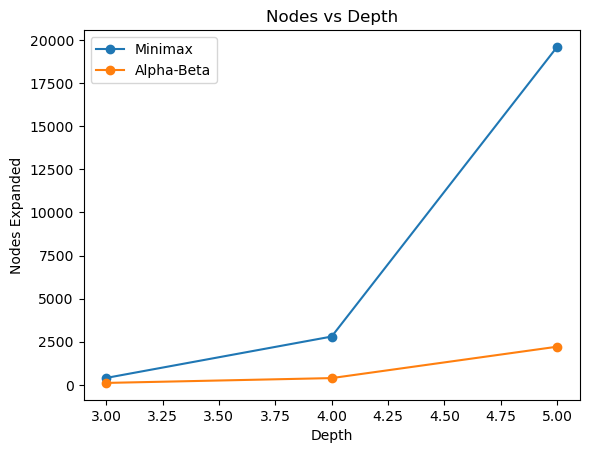

In [8]:
def plot_nodes(results):
    depths = [r[0] for r in results]
    nodes_mm = [r[1] for r in results]
    nodes_ab = [r[3] for r in results]
    plt.figure()
    plt.plot(depths, nodes_mm, marker='o', label='Minimax')
    plt.plot(depths, nodes_ab, marker='o', label='Alpha-Beta')
    plt.xlabel('Depth')
    plt.ylabel('Nodes Expanded')
    plt.title('Nodes vs Depth')
    plt.legend()
    plt.show()

plot_nodes(res)


### Plot: Time vs Depth


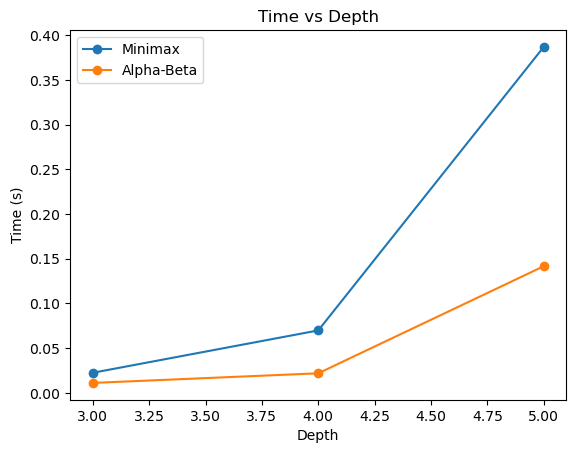

In [9]:
def plot_time(results):
    depths = [r[0] for r in results]
    t_mm = [r[2] for r in results]
    t_ab = [r[4] for r in results]
    plt.figure()
    plt.plot(depths, t_mm, marker='o', label='Minimax')
    plt.plot(depths, t_ab, marker='o', label='Alpha-Beta')
    plt.xlabel('Depth')
    plt.ylabel('Time (s)')
    plt.title('Time vs Depth')
    plt.legend()
    plt.show()

plot_time(res)


## Quick Sanity Test
Let the AI (MAX) choose a move from the initial board at depth 5.


In [10]:
s0 = new_state()
print_board(s0)
nodes, move, elapsed, cutoffs = pick_ai_move(lambda st,dep: alphabeta(st,dep), s0, depth=5)
print(f"AI suggests column {move} | nodes={nodes}, cutoffs={cutoffs}, time={elapsed:.3f}s")


. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
0 1 2 3 4 5 6
AI suggests column 3 | nodes=1359, cutoffs=225, time=0.117s


In [13]:
play_human_vs_ai(depth=6, use_alphabeta=True)


. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
0 1 2 3 4 5 6
AI selects column 3 (score=0, nodes=4540, cutoffs=785, time=0.312s)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 3, 4, 5, 6]:  3


. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . . X . . .
0 1 2 3 4 5 6
AI selects column 3 (score=-2, nodes=9217, cutoffs=1783, time=0.622s)
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . . O . . .
. . . X . . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 3, 4, 5, 6]:  4


. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . . O . . .
. . . X O . .
0 1 2 3 4 5 6
AI selects column 3 (score=9, nodes=4297, cutoffs=1027, time=0.353s)
. . . . . . .
. . . . . . .
. . . X . . .
. . . X . . .
. . . O . . .
. . . X O . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 3, 4, 5, 6]:  2


. . . . . . .
. . . . . . .
. . . X . . .
. . . X . . .
. . . O . . .
. . O X O . .
0 1 2 3 4 5 6
AI selects column 2 (score=13, nodes=4523, cutoffs=1202, time=0.425s)
. . . . . . .
. . . . . . .
. . . X . . .
. . . X . . .
. . X O . . .
. . O X O . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 3, 4, 5, 6]:  2


. . . . . . .
. . . . . . .
. . . X . . .
. . O X . . .
. . X O . . .
. . O X O . .
0 1 2 3 4 5 6
AI selects column 3 (score=15, nodes=3306, cutoffs=953, time=0.320s)
. . . . . . .
. . . X . . .
. . . X . . .
. . O X . . .
. . X O . . .
. . O X O . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 3, 4, 5, 6]:  3


. . . O . . .
. . . X . . .
. . . X . . .
. . O X . . .
. . X O . . .
. . O X O . .
0 1 2 3 4 5 6
AI selects column 2 (score=18, nodes=2218, cutoffs=637, time=0.226s)
. . . O . . .
. . . X . . .
. . X X . . .
. . O X . . .
. . X O . . .
. . O X O . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 4, 5, 6]:  4


. . . O . . .
. . . X . . .
. . X X . . .
. . O X . . .
. . X O O . .
. . O X O . .
0 1 2 3 4 5 6
AI selects column 4 (score=19, nodes=2889, cutoffs=846, time=0.297s)
. . . O . . .
. . . X . . .
. . X X . . .
. . O X X . .
. . X O O . .
. . O X O . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 4, 5, 6]:  4


. . . O . . .
. . . X . . .
. . X X O . .
. . O X X . .
. . X O O . .
. . O X O . .
0 1 2 3 4 5 6
AI selects column 2 (score=19, nodes=3335, cutoffs=956, time=0.338s)
. . . O . . .
. . X X . . .
. . X X O . .
. . O X X . .
. . X O O . .
. . O X O . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 4, 5, 6]:  4


. . . O . . .
. . X X O . .
. . X X O . .
. . O X X . .
. . X O O . .
. . O X O . .
0 1 2 3 4 5 6
AI selects column 4 (score=19, nodes=2363, cutoffs=718, time=0.250s)
. . . O X . .
. . X X O . .
. . X X O . .
. . O X X . .
. . X O O . .
. . O X O . .
0 1 2 3 4 5 6


Your move [0, 1, 2, 5, 6]:  2


. . O O X . .
. . X X O . .
. . X X O . .
. . O X X . .
. . X O O . .
. . O X O . .
0 1 2 3 4 5 6
AI selects column 6 (score=22, nodes=481, cutoffs=163, time=0.081s)
. . O O X . .
. . X X O . .
. . X X O . .
. . O X X . .
. . X O O . .
. . O X O . X
0 1 2 3 4 5 6


Your move [0, 1, 5, 6]:  6


. . O O X . .
. . X X O . .
. . X X O . .
. . O X X . .
. . X O O . O
. . O X O . X
0 1 2 3 4 5 6
AI selects column 6 (score=25, nodes=327, cutoffs=111, time=0.064s)
. . O O X . .
. . X X O . .
. . X X O . .
. . O X X . X
. . X O O . O
. . O X O . X
0 1 2 3 4 5 6


Your move [0, 1, 5, 6]:  6


. . O O X . .
. . X X O . .
. . X X O . O
. . O X X . X
. . X O O . O
. . O X O . X
0 1 2 3 4 5 6
AI selects column 1 (score=30, nodes=274, cutoffs=99, time=0.054s)
. . O O X . .
. . X X O . .
. . X X O . O
. . O X X . X
. . X O O . O
. X O X O . X
0 1 2 3 4 5 6


Your move [0, 1, 5, 6]:  6


. . O O X . .
. . X X O . O
. . X X O . O
. . O X X . X
. . X O O . O
. X O X O . X
0 1 2 3 4 5 6
AI selects column 6 (score=31, nodes=192, cutoffs=69, time=0.044s)
. . O O X . X
. . X X O . O
. . X X O . O
. . O X X . X
. . X O O . O
. X O X O . X
0 1 2 3 4 5 6


Your move [0, 1, 5]:  0


. . O O X . X
. . X X O . O
. . X X O . O
. . O X X . X
. . X O O . O
O X O X O . X
0 1 2 3 4 5 6
AI selects column 0 (score=36, nodes=67, cutoffs=26, time=0.014s)
. . O O X . X
. . X X O . O
. . X X O . O
. . O X X . X
X . X O O . O
O X O X O . X
0 1 2 3 4 5 6


Your move [0, 1, 5]:  0


. . O O X . X
. . X X O . O
. . X X O . O
O . O X X . X
X . X O O . O
O X O X O . X
0 1 2 3 4 5 6
AI selects column 0 (score=1000000000, nodes=28, cutoffs=10, time=0.005s)
. . O O X . X
. . X X O . O
X . X X O . O
O . O X X . X
X . X O O . O
O X O X O . X
0 1 2 3 4 5 6


Your move [0, 1, 5]:  0


. . O O X . X
O . X X O . O
X . X X O . O
O . O X X . X
X . X O O . O
O X O X O . X
0 1 2 3 4 5 6
AI selects column 0 (score=1000000000, nodes=16, cutoffs=5, time=0.004s)
X . O O X . X
O . X X O . O
X . X X O . O
O . O X X . X
X . X O O . O
O X O X O . X
0 1 2 3 4 5 6


Your move [1, 5]:  5


X . O O X . X
O . X X O . O
X . X X O . O
O . O X X . X
X . X O O . O
O X O X O O X
0 1 2 3 4 5 6
AI selects column 5 (score=1000000000, nodes=4, cutoffs=1, time=0.001s)
X . O O X . X
O . X X O . O
X . X X O . O
O . O X X . X
X . X O O X O
O X O X O O X
0 1 2 3 4 5 6
AI (MAX/X) wins!


In [11]:

import itertools
_trace_id = itertools.count()

def trace_alphabeta(s: State, depth: int, alpha=-math.inf, beta=math.inf, player_view=MAX, indent=0):
    """Returns (value, action) and prints a trace line-by-line.
    Uses ordered_actions() for child ordering so trace matches actual search order."""
    nid = next(_trace_id)
    global_counter.nodes += 1
    prefix = "  " * indent
    node_player = "MAX" if s.player == MAX else "MIN"
    acts = actions(s)
    print(f"{prefix}Node {nid}: depth={depth} player={node_player} alpha={alpha} beta={beta} legal={acts}")
    if depth == 0 or terminal_test(s):
        val = evaluate(s, player_view)
        print(f"{prefix}  -> Leaf eval = {val}")
        return val, None

    if s.player == MAX:
        best_val, best_act = -math.inf, None
        for a in ordered_actions(s):
            print(f"{prefix}  -> Explore action {a}")
            v, _ = trace_alphabeta(result(s, a), depth-1, alpha, beta, player_view, indent+2)
            print(f"{prefix}  <- Action {a} returned {v}")
            if v > best_val:
                best_val, best_act = v, a
            alpha = max(alpha, v)
            if alpha >= beta:
                global_counter.cutoffs += 1
                print(f"{prefix}  ## CUTOFF (alpha={alpha} >= beta={beta}) after action {a}")
                break
        print(f"{prefix}  => Node {nid} returns (val={best_val}, act={best_act})")
        return best_val, best_act
    else:
        best_val, best_act = math.inf, None
        for a in ordered_actions(s):
            print(f"{prefix}  -> Explore action {a}")
            v, _ = trace_alphabeta(result(s, a), depth-1, alpha, beta, player_view, indent+2)
            print(f"{prefix}  <- Action {a} returned {v}")
            if v < best_val:
                best_val, best_act = v, a
            beta = min(beta, v)
            if alpha >= beta:
                global_counter.cutoffs += 1
                print(f"{prefix}  ## CUTOFF (alpha={alpha} >= beta={beta}) after action {a}")
                break
        print(f"{prefix}  => Node {nid} returns (val={best_val}, act={best_act})")
        return best_val, best_act

def run_trace(s: State, depth: int):
    global_counter.reset()
    # reset trace id
    global _trace_id
    _trace_id = itertools.count()
    print("=== TRACE START ===")
    val, act = trace_alphabeta(s, depth, -math.inf, math.inf, player_view=MAX, indent=0)
    print("=== TRACE END ===")
    print(f"Result: chosen action={act}, value={val}, nodes={global_counter.nodes}, cutoffs={global_counter.cutoffs}")
# 

In [12]:
# run this after the cell above
s0 = new_state()          # initial board
run_trace(s0, depth=4)    # choose depth small enough to keep trace readable

=== TRACE START ===
Node 0: depth=4 player=MAX alpha=-inf beta=inf legal=[0, 1, 2, 3, 4, 5, 6]
  -> Explore action 3
    Node 1: depth=3 player=MIN alpha=-inf beta=inf legal=[0, 1, 2, 3, 4, 5, 6]
      -> Explore action 2
        Node 2: depth=2 player=MAX alpha=-inf beta=inf legal=[0, 1, 2, 3, 4, 5, 6]
          -> Explore action 3
            Node 3: depth=1 player=MIN alpha=-inf beta=inf legal=[0, 1, 2, 3, 4, 5, 6]
              -> Explore action 4
                Node 4: depth=0 player=MAX alpha=-inf beta=inf legal=[0, 1, 2, 3, 4, 5, 6]
                  -> Leaf eval = 8
              <- Action 4 returned 8
              -> Explore action 1
                Node 5: depth=0 player=MAX alpha=-inf beta=8 legal=[0, 1, 2, 3, 4, 5, 6]
                  -> Leaf eval = 8
              <- Action 1 returned 8
              -> Explore action 5
                Node 6: depth=0 player=MAX alpha=-inf beta=8 legal=[0, 1, 2, 3, 4, 5, 6]
                  -> Leaf eval = 8
              <- Action 5 re